In [10]:
using LaTeXStrings
using StatsPlots
using PrettyTables
using Distributions
pyplot()
using StatsBase
using Corpuscles
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using LinearAlgebra
using JLD2
#gr()
#theme(:gruvbox_dark)

In [6]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

print("ss has ")
print(length(fileList_ss))
print(" files, bb has ")
print(length(fileList_bb))
print(" files, cc has ")
print(length(fileList_cc))
print(" files, gg has ")
print(length(fileList_gg))
print(" files")
sampleList=[fileList_ss, fileList_bb, fileList_cc, fileList_gg]

ss has 100 files, bb has 100 files, cc has 100 files, gg has 100 files

4-element Array{Array{String,1},1}:
 ["/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.0_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.10_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.11_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.12_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.13_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.14_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.15_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.16_DST.slcio", "/nfs/dust/ilc/user/jstrube

In [7]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end

function recoil_mass(μ₁, μ₂)
    E_initial = 250.0  #can update to make it accurate for the event's flucation, with p as well?
    px_initial = 0.0 # "in full sim & SGV, correct for crossing angle\n" -Jan
    E_initial = 2.0sqrt((0.5*E_initial)^2 + px_initial^2)
    "    end\n",
    "    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)\n",
    "    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)\n",
#can use a sort function where the key to sort on is dot(p, p)

LoadError: syntax: incomplete: premature end of input

In [8]:
function zMuonIndices(event, threshold, MCTruth=false) #for certain events it returns an empty candidatePairs
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    if MCTruth==false
        collection = getCollection(event, "PandoraPFOs")
        recoLinks = getCollection(event, "RecoMCTruthLink")
        rel=LCIO.LCRelationNavigator(recoLinks)
    elseif MCTruth==true
        collection = getCollection(event, "MCParticle")
    end
    
    for particle in collection
        if MCTruth==false
            mcp = getRelatedToObjects(rel, particle)
            if length(mcp)>0
                MCparticle=mcp[1]
            else
                continue
            end
        elseif MCTruth==true
            MCparticle=particle
        end
        iParticle += 1
        if abs(getPDG(MCparticle))==13 && getGeneratorStatus(MCparticle)==1
            if getCharge(MCparticle)==1
                push!(posMuonList, (particle, iParticle))
            elseif getCharge(MCparticle)==-1
                push!(negMuonList, (particle, iParticle))
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    if abs(candidateDiff)>threshold
        indices=[0,0]
    elseif length(candidatePair)>0
        indices = [candidatePair[1][2], candidatePair[2][2]]
    end
    return indices
end

zMuonIndices (generic function with 2 methods)

In [13]:
perSampleFalsePosIndex=[]
perSamplePurity=[]
perSampleNoParents=[]
perSampleRecoPDG=[]
recoMuonMassList = []
mcMuonMassList = []
differenceList = []

0-element Array{Any,1}

In [ ]:
for sample in [fileList_ss]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    for FILENAME in sample
        iFile+=1
   #     if iFile
    #        break
     #   end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
       #         if iEvent>100
        #            break
         #       end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        fareDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    push!(perSampleFalsePosIndex, falsePosEventIndexList)
    push!(perSamplePurity, mean(perFilePurity))
    push!(perSampleNoParents, mean(perFileNoParents))
    push!(perSampleRecoPDG, recoPDG)
    push!(differenceList, perSampleDifferenceList)
end
@save "ssFalsePosIndex" perSampleFalsePosIndex[1]
@save "ssFalsePosIndex" perSamplePurity[1]
@save "ssNoParents" perSampleNoParents[1]
@save "ssRecoPDG" perSampleRecoPDG[1]
@save "ssDifferenceList" differenceList[1]

In [ ]:
for sample in [fileList_bb]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    for FILENAME in sample
        iFile+=1
   #     if iFile
    #        break
     #   end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
       #         if iEvent>100
        #            break
         #       end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        fareDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    push!(perSampleFalsePosIndex, falsePosEventIndexList)
    push!(perSamplePurity, mean(perFilePurity))
    push!(perSampleNoParents, mean(perFileNoParents))
    push!(perSampleRecoPDG, recoPDG)
    push!(differenceList, perSampleDifferenceList)
end
@save "bbFalsePosIndex" perSampleFalsePosIndex[2]
@save "bbFalsePosIndex" perSamplePurity[2]
@save "bbNoParents" perSampleNoParents[2]
@save "bbRecoPDG" perSampleRecoPDG[2]
@save "bbDifferenceList" differenceList[2]

In [ ]:
for sample in [fileList_cc]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    for FILENAME in sample
        iFile+=1
   #     if iFile
    #        break
     #   end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
       #         if iEvent>100
        #            break
         #       end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        fareDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    push!(perSampleFalsePosIndex, falsePosEventIndexList)
    push!(perSamplePurity, mean(perFilePurity))
    push!(perSampleNoParents, mean(perFileNoParents))
    push!(perSampleRecoPDG, recoPDG)
    push!(differenceList, perSampleDifferenceList)
end
@save "ccFalsePosIndex" perSampleFalsePosIndex[3]
@save "ccFalsePosIndex" perSamplePurity[3]
@save "ccNoParents" perSampleNoParents[3]
@save "ccRecoPDG" perSampleRecoPDG[3]
@save "ccDifferenceList" differenceList[3]

In [ ]:
for sample in [fileList_gg]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    for FILENAME in sample
        iFile+=1
   #     if iFile
    #        break
     #   end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
       #         if iEvent>100
        #            break
         #       end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        fareDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    push!(perSampleFalsePosIndex, falsePosEventIndexList)
    push!(perSamplePurity, mean(perFilePurity))
    push!(perSampleNoParents, mean(perFileNoParents))
    push!(perSampleRecoPDG, recoPDG)
    push!(differenceList, perSampleDifferenceList)
end
@save "ggFalsePosIndex" perSampleFalsePosIndex[4]
@save "ggFalsePosIndex" perSamplePurity[4]
@save "ggNoParents" perSampleNoParents[4]
@save "ggRecoPDG" perSampleRecoPDG[4]
@save "ggDifferenceList" differenceList[4]

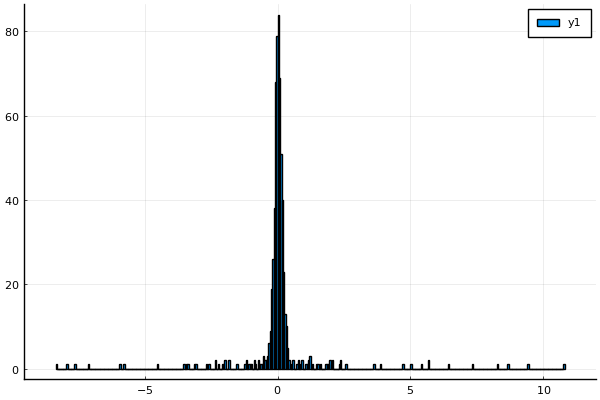

In [55]:
#Z finder looks at what particle actually is, not what reco thinks it is. fix that.\
#Plot recoil mass of whatever recoils against Z\
#Check effiiency and purity of z muon reco\
#Plot MC z muons\
#perSampleFalsePosIndex
histogram(differenceList[1])

In [12]:
perSamplePurity

1-element Array{Any,1}:
 1.0

In [13]:
perSampleNoParents

1-element Array{Any,1}:
 0.0

In [18]:
perSampleRecoPDG

4-element Array{Any,1}:
 Any[13, -13, -13, 13, 13, -13, 13, -13, -13, 13  …  13, -13, 13, -13, 13, -13, -13, 13, 13, -13]
 Any[13, -13, 13, -13, 13, -13, 13, -13, -13, 13  …  -13, 13, 13, -13, -13, 13, 13, -13, 13, -13]
 Any[-13, 13, -13, 13, 13, -13, -13, 13, 13, -13  …  -13, 13, -13, 13, -13, 13, -13, 13, -13, 13]
 Any[13, -13, -13, 13, -13, 13, -13, 13, -13, 13  …  -13, 13, 13, -13, -13, 13, -13, 13, -13, 13]

Block 1:
                        if length(getParents(MCParticle))>0
                            noParents=false
                        elseif length(getParents(MCParticle))==0
                            nNoParents+=1
                            push!(noParentIndexList, (iFile, iEvent))
                        end
                        push!(recoPDG, getPDG(MCParticle))
                        lineage=getParents(MCParticle)
                        while length(lineage)>0
                            nextGen=[]
                            for parent in lineage
                                if firstIsDaughterOfZ==true
                                    lineage=[]
                                    break
                                end
                                if abs(getPDG(parent))==23
                                    firstIsDaughterOfZ=true
                                end
                                for grandparent in getParents(parent)
                                    push!(nextGen, grandparent)
                                end
                            end
                            lineage=nextGen
                        end

Block 2: if length(getParents(MCParticle))>0
                            noParents=false
                        elseif length(getParents(MCParticle))==0
                            nNoParents+=1
                            push!(noParentIndexList, (iFile, iEvent))
                        end
                        push!(recoPDG, getPDG(MCParticle))
                        lineage=getParents(MCParticle)
                        while length(lineage)>0
                            nextGen=[]
                            for parent in lineage
                                if areDaughtersOfZ==true
                                    lineage=[]
                                    break
                                end
                                if abs(getPDG(parent))==23
                                    fareDaughtersOfZ=true
                                end
                                for grandparent in getParents(parent)
                                    push!(nextGen, grandparent)
                                end
                            end
                            lineage=nextGen
                        end